In [38]:
import vamb

import pandas as pd

import os

import numpy as np
from sklearn.manifold import TSNE

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
BASE_DIR = os.getcwd()

CHECKM_OUTDIR = os.path.join(BASE_DIR, 'example_input_data/new_simulations/camisim_outputs/vamb_outputs/checkm_results')

if not os.path.exists(CHECKM_OUTDIR):
    os.mkdir(CHECKM_OUTDIR)

# How We Will do Benchmarking and Scoring

# CheckM

One fairly efficient way that we can do benchmarking is to use CheckM which is a package built to support assessment of metagenome binning. CheckM can provide us with some key metrics for assessig binning quality in the form of Completeness, Contamination, and Strain Heterogeneity.


### Completeness
To quote the authors' original [paper](https://genome.cshlp.org/content/25/7/1043):

*"Genome completeness is estimated as the number of marker sets present in a genome taking into account that only a portion of a marker set may be identified*

$$\Large \frac{\sum_{s \in M} \frac{|s \cap G_M|}{|s|}}{|M|}$$

*where s is a set of collocated marker genes; M is the set of all collocated marker sets s; and GM is the set of marker genes identified in a genome*"


### Contamination
*"Genome contamination is estimated from the number of multicopy marker genes identified in each marker set*

$$\Large \frac{\sum_{s \in M} \frac{|\sum_{g \in s} C_g|}{|s|}}{|M|}$$

*where Cg is N − 1 for a gene g identified N ≥ 1 times, and 0 for a missing gene*"


### Strain Heterogeneity

Finally, it is possible that multiple strains or even closely related species result in contigs being binned together. Strain heterogeneity captures this as the fraction of multicopy gene pairs above a specified amino acid identity (AAI) threshold

$$\Large \frac{\sum_{g \in G} \sum_{i=1}^{|g|} \sum_{j=i+1}^{|g|} aai(g_i, g_j, t) } {\sum_{g \in G} \sum_{i=1}^{|g|} \sum_{j=i+1}^{|g|} 1}$$

*where g = {g1,g2,…,gN} is the set of hits to a marker gene; G is the set of all marker genes; and aai is 1 if the AAI between gi and gj is greater than t (default = 0.9) and 0 otherwise.*

These marker gene sets represent lineage-specific groups of genes that CheckM can use to efficiently perform these calculations and determine whether a grouped of binned contigs belongs to the same genome or different genomes and whether they cover the breadth of any given genome.

In [73]:
bins_inpath = os.path.join(BASE_DIR, 'example_input_data/new_simulations/camisim_outputs/vamb_outputs/dvae_bins')

#!~/miniconda3/envs/vamb_env/bin/checkm taxonomy_wf -t 32 -x fna genus <taxon> $bins_inpath $CHECKM_OUTDIR
!~/miniconda3/envs/vamb_env/bin/checkm lineage_wf -t 32 -x fna $bins_inpath $CHECKM_OUTDIR

[2021-02-27 23:15:00] INFO: CheckM v1.1.3
[2021-02-27 23:15:00] INFO: checkm lineage_wf -t 32 -x fna /home/pathinformatics/jupyter_projects/vamb/stanford_cs230_project/example_input_data/new_simulations/camisim_outputs/vamb_outputs/dvae_bins /home/pathinformatics/jupyter_projects/vamb/stanford_cs230_project/example_input_data/new_simulations/camisim_outputs/vamb_outputs/checkm_results
[2021-02-27 23:15:00] INFO: [CheckM - tree] Placing bins in reference genome tree.
[2021-02-27 23:15:00] INFO: Identifying marker genes in 10 bins with 32 threads:
    Finished processing 10 of 10 (100.00%) bins.
[2021-02-27 23:15:13] INFO: Saving HMM info to file.
[2021-02-27 23:15:13] INFO: Calculating genome statistics for 10 bins with 32 threads:
    Finished processing 10 of 10 (100.00%) bins.
[2021-02-27 23:15:13] INFO: Extracting marker genes to align.
[2021-02-27 23:15:13] INFO: Parsing HMM hits to marker genes:
    Finished parsing hits for 10 of 10 (100.00%) bins.
[2021-02-27 23:15:13] INFO: Ext

# Profiling Encodings

We have a way of scoring the final output of this process which is to calculate how the bins actually map to genomes but we perform this clustering in the encoding space so it would be nice to also look at the encoding space itself.

(1342, 3)


<AxesSubplot:xlabel='0', ylabel='1'>

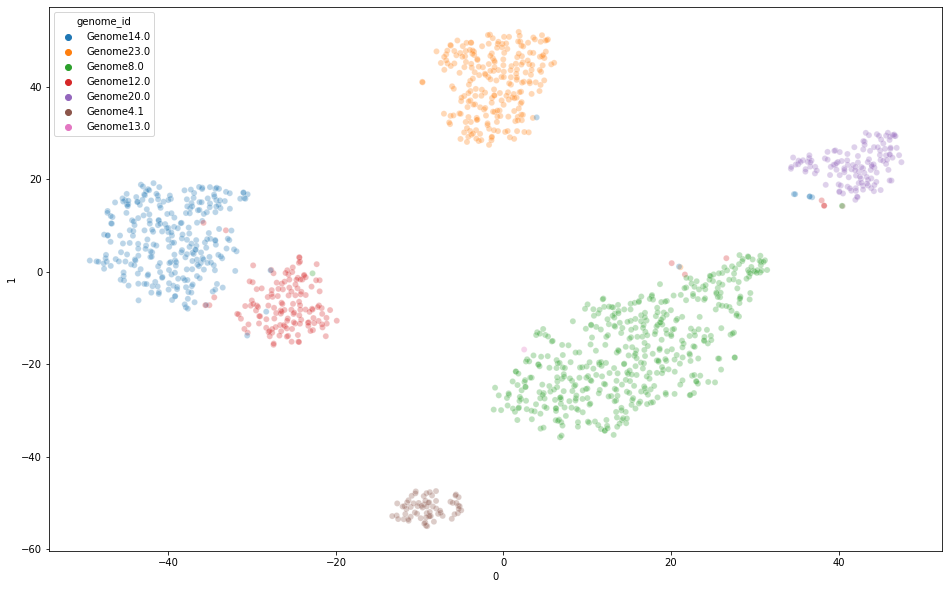

In [78]:
latent_encoding_labels = pd.read_csv(os.path.join(BASE_DIR, 'example_input_data/new_simulations/camisim_outputs/vamb_outputs/encoding_mapping.tsv'), sep='\t')

latent_output_path = os.path.join(BASE_DIR, 'example_input_data/new_simulations/camisim_outputs/vamb_outputs/latent_space.npy')

with open(latent_output_path, 'rb') as infile:
    latent_space = np.load(infile)

tsne_results = pd.DataFrame(TSNE(n_components=2).fit_transform(latent_space))
tsne_results['genome_id'] = latent_encoding_labels['genome_id']

print(tsne_results.shape)


plt.figure(figsize=(16,10))
sns.scatterplot(
    x=0, 
    y=1,
    hue='genome_id',
    data=tsne_results,
    legend="full",
    alpha=0.3
)

In [26]:
clusters_tsv_path = os.path.join(BASE_DIR, 'example_input_data/new_simulations/camisim_outputs/vamb_outputs/clusters.tsv')

pd.read_csv(clusters_tsv_path, sep='\t')

,cluster_1,S0C49355
0,cluster_1,S0C29459
1,cluster_1,S0C42727
2,cluster_1,S0C16826
3,cluster_1,S0C177
4,cluster_1,S0C45678
...,...,...
1298,cluster_4,S0C14627
1299,cluster_4,S0C48135
1300,cluster_4,S0C19660
1301,cluster_4,S0C31833


# Under Construction

# Custom

### Recall
In order to effectively benchmark these binning exercises, we need to understand precision and recall. Recall in this case would be the number of basepairs in a given genome covered by the bin for that genome:

$$\Large Recall = \frac{bases_{genome} \bigcap (  \bigcup_{i=1}^{n} bases_{contig^i} )} {bases_{genome} \bigcap  (\bigcup_{i=1}^{all contigs} bases_{contig^i} )} $$

Where $n$ is the number of contigs in a given bin of contigs


### Precision

While the precision for a given bin would be the number of bases of a genome represented in a bin as a proportion of the number of bases in any genome that are captured in that bin:


$$\Large Precision = \frac{ \bigcup_{j=1}^{K}( bases_{genome}) \bigcap (  \bigcup_{i=1}^{n} bases_{contig^i} )} {bases_{genome} \bigcap  (\bigcup_{i=1}^{n} bases_{contig^i} )} $$

Where $n$ is the number of contigs in a given bin of contigs and $K$ is the number of genomes

In [3]:
# First load in the Reference
reference_path = os.path.join(BASE_DIR, 'benchmarking_data/airways/reference.tsv')

!head $reference_path # show first 10 lines of reference file

with open(reference_path) as reference_file:
    reference = vamb.benchmark.Reference.from_file(reference_file)

S23C236194	OTU_97.38699.0	CP013953.1	405835	408637
S23C27593	OTU_97.44406.0	CP015430.1	1591817	1594726
S23C53437	OTU_97.35057.0	CP012974.1	260542	266700
S23C191539	OTU_97.16597.0	CP010116.1	1675948	1678686
S23C111210	OTU_97.20680.0	CP013619.1	408162	411064
S23C216129	OTU_97.409.0	CP013957.1	103779	106015
S23C2782	OTU_97.45246.0	CP007573.1	1941619	1956892
S23C9729	OTU_97.44851.0	CP015426.1	1099587	1121671
S23C36165	OTU_97.409.0	CP013957.1	427732	429801
S23C90379	OTU_97.2104.0	CP019196.1	300725	303071


In [4]:
taxonomy_path = os.path.join(BASE_DIR, 'benchmarking_data/airways/taxonomy.tsv')

!head $taxonomy_path # show first 10 lines of reference file

with open(taxonomy_path) as taxonomy_file:
    reference.load_tax_file(taxonomy_file)

OTU_97.39766.0	Corynebacterium pseudotuberculosis	Corynebacterium
OTU_97.7195.0	Acinetobacter baumannii	Acinetobacter
OTU_97.34725.0	Staphylococcus aureus	Staphylococcus
OTU_97.1051.0	Corynebacterium ulcerans	Corynebacterium
OTU_97.34663.0	Staphylococcus aureus	Staphylococcus
OTU_97.8581.0	Corynebacterium doosanense	Corynebacterium
OTU_97.8702.0	Flavobacterium psychrophilum	Flavobacterium
OTU_97.31374.1	Corynebacterium ulcerans	Corynebacterium
OTU_97.479.0	Flavobacterium gilvum	Flavobacterium
OTU_97.37290.0	Staphylococcus equorum	Staphylococcus


In [5]:
with open( os.path.join(BASE_DIR, 'example_input_data/new_simulations/camisim_outputs/vamb_outputs/clusters.tsv') ) as clusters_file:
    vamb_clusters = vamb.vambtools.read_clusters(clusters_file)
    vamb_bins = vamb.benchmark.Binning(vamb_clusters, reference, minsize=200000)

KeyError: 'Contigname S0C3223 not in reference'